<a href="https://colab.research.google.com/github/alimoorreza/CS195-Fall24-Notebook-4/blob/main/cs195_notebook4_faster_rcnn_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Object detection: training/fine-tuning a pre-trained detector model**



### You need to fine-tune pretrained detectors such as Faster R-CNN and Mask R-CNN. These pretrained detectors have been using on the COCO dataset and can recognize 91 objects, including `person`, `dog`, and `cat`.
  * [Microsoft COCO (Common Object in COntext)](https://cocodataset.org/#explore)

### Your goal for this assignment is to fine-tune two pretrained models using our own UWSDet1 dataset. This dataset_, created by Drake University and Indiana University,_ contains images of various underwater animals. Our aim is to train the model to improve its ability to detect certain underwater animals.
  * __`Dolphin`__
  * __`Seal`__
  * __`Shark`__
  * __`Whale`__

###__UWSDet1 dataset__ link for fine-tuning Faster R-CNN and Mask R-CNN:
- [https://analytics.drake.edu/~reza/teaching/cs195_fall24/datasets/UWSDetv1.zip](https://analytics.drake.edu/~reza/teaching/cs195_fall24/datasets/UWSDetv1.zip)
- I have uploaded the dataset on Blackboard as well; you could download it from there as well.
- Alternately, please execute the following lines or manually download this dataset and upload it to your Google Drive:
  - !wget https://analytics.drake.edu/~reza/teaching/cs195_fall24/datasets/UWSDetv1.zip
  - !unzip UWSDetv1.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%shell
pip install cython

In [ ]:
import torch
print(torch.__version__)

2.5.0+cu121


In [ ]:
%%shell
#pip uninstall -y torch
pip install torch==1.11.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
pip install torchvision==0.12.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 839.0 kB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.0+cu121
    Uninstalling torch-2.5.0+cu121:
      Successfully uninstalled torch-2.5.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.13.2 requires torch>=1.13.0, but you have torch 1.11.0+cu102 which is incompatible.
torchaudio 2.5.0+cu121 requires torch==2.5.0, but you have torch 1.11.0+cu102 which is incompatible.
torchvision 0.20.0+cu121 requires torch==2.5.0, but you have torch 1.11.0+cu102 which is incompatible.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 68.2 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing instal

##__Super important: restart your runtime by Runtime-->Restart session__
###Otherwise, the newly installed Torch version won't be loaded into your Colab. Colab sometimes tries to load the preinstalled version of Torch from cache memory (I know it's annoying, but sorry, you may have to do this)!

In [ ]:
import torch
print(torch.__version__)

1.11.0+cu102


In [ ]:
%%shell
if [ -d "cs195_fall24_detection" ]; then rm -rf cs195_fall24_detection; fi
git clone https://github.com/alimoorreza/cs195_fall24_detection.git

cp cs195_fall24_detection/utils.py ./
cp cs195_fall24_detection/transforms.py ./
cp cs195_fall24_detection/coco_eval.py ./
cp cs195_fall24_detection/engine.py ./
cp cs195_fall24_detection/coco_utils.py ./


if [ -d "pycocotools" ]; then rm -rf pycocotools; fi
mkdir pycocotools
cp cs195_fall24_detection/coco.py pycocotools/coco.py
cp cs195_fall24_detection/cocoeval.py pycocotools/cocoeval.py
cp cs195_fall24_detection/mask.py pycocotools/mask.py


Cloning into 'cs195_fall24_detection'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 30 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 33.18 KiB | 1.84 MiB/s, done.
Resolving deltas: 100% (7/7), done.


boundding boxes: 
[[57, 157, 2110, 1230]]


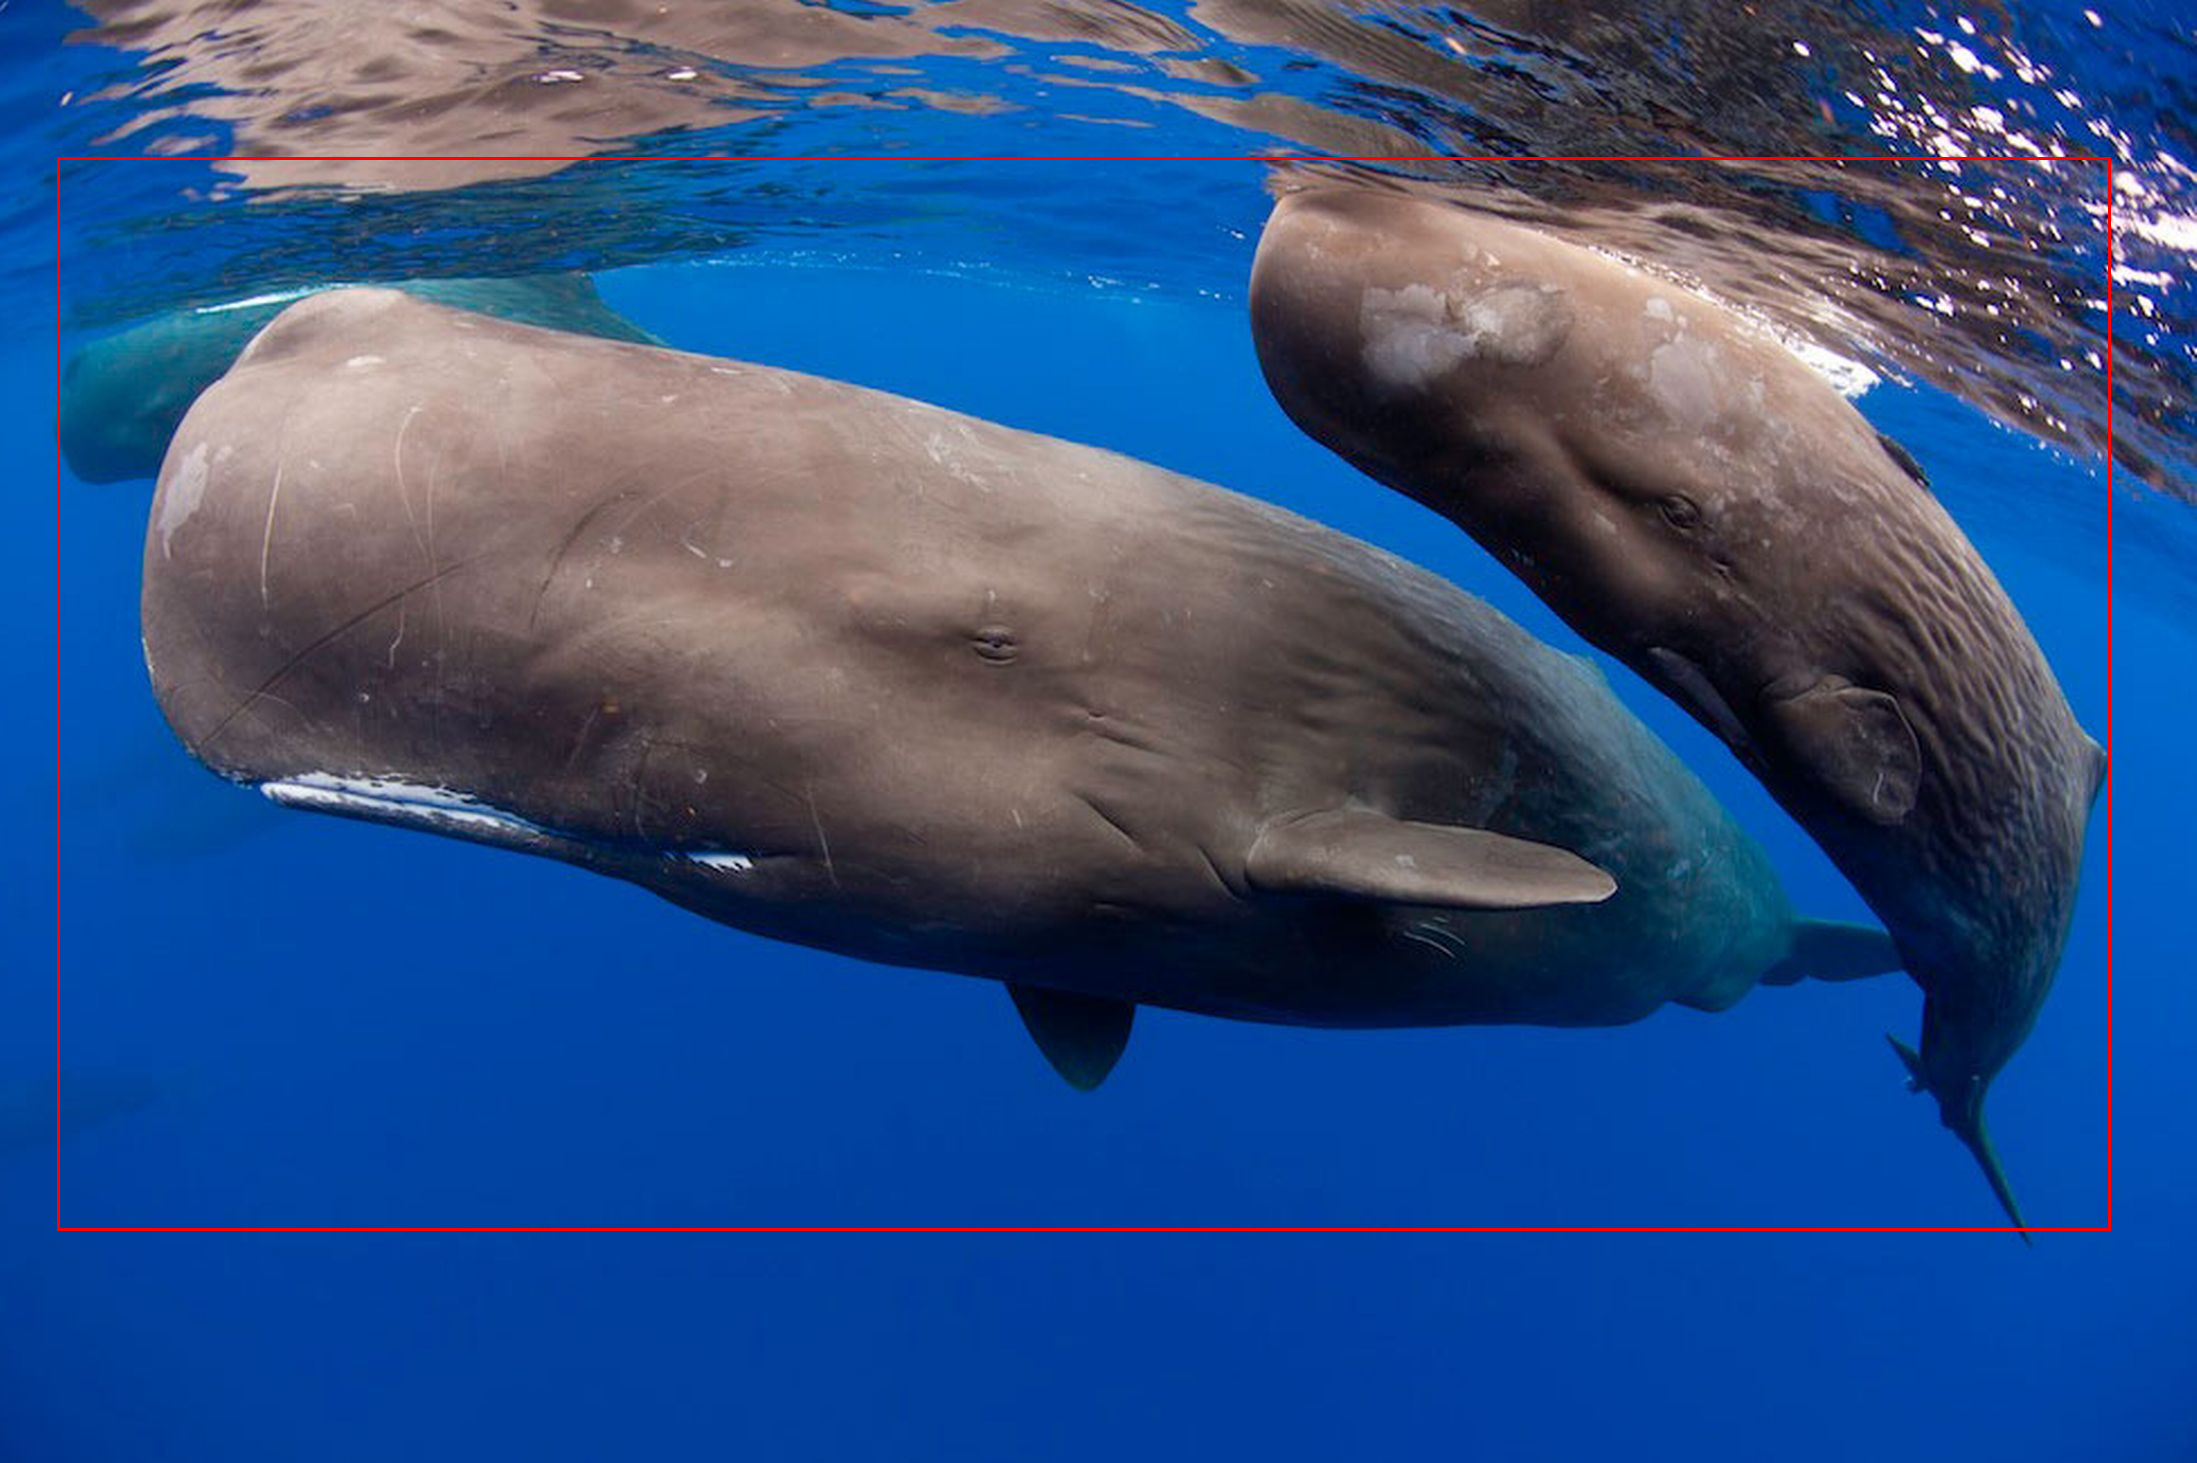

In [ ]:
# a sample visualization of bound-boxes associated with the objects (pedestrian)

import numpy as np
from PIL import Image, ImageDraw
root  = '/content/drive/MyDrive/cs195_fall24/detection/'

image_name = 'uw_animal_0099.png'
mask = Image.open(root + '/UWSDetv1/AnimMasks/' + image_name)
mask = np.array(mask)

# instances are encoded as different colors
obj_ids = np.unique(mask)
# first id is the background, so remove it
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set
# of binary masks
masks = mask == obj_ids[:, None, None]

# get bounding box coordinates for each mask
num_objs = len(obj_ids)
boxes = []
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])

print(f"boundding boxes: \n{boxes}")

# draw the bounding boxes using PIL.ImageDraw, as we did in our in-class activity #1
rgb_image = Image.open(root + '/UWSDetv1/PNGImages/' + image_name)
draw = ImageDraw.Draw(rgb_image)

# draw rectangular bouding boxes on the image
for box in boxes:
    draw.rectangle(box, outline="red", width=3)

# show the image
rgb_image


In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class AnimalDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "AnimMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path    = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path   = os.path.join(self.root, "AnimMasks", self.masks[idx])
        img         = Image.open(img_path).convert("RGB")
        mask        = Image.open(mask_path) # note that we haven't converted the mask to RGB because each color corresponds to a different instance with 0 being background



        mask        = np.array(mask)
        obj_ids     = np.unique(mask) # instances are encoded as different colors
        obj_ids     = obj_ids[1:]     # first id is the background, so remove it

        # split the color-encoded mask into a set of binary masks
        masks       = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs    = len(obj_ids)
        boxes       = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes       = torch.as_tensor(boxes, dtype=torch.float32)
        labels      = torch.ones((num_objs,), dtype=torch.int64) # there is only one class
        masks       = torch.as_tensor(masks, dtype=torch.uint8)

        image_id    = torch.tensor([idx])
        area        = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd     = torch.zeros((num_objs,), dtype=torch.int64) # suppose all instances are not crowd

        target              = {}
        target["boxes"]     = boxes
        target["labels"]    = labels
        target["masks"]     = masks
        target["image_id"]  = image_id
        target["area"]      = area
        target["iscrowd"]   = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

##**Notice below that we are saving attributes such as `boxes,` `labels,` and `masks` for each image, which will be useful during the training of our models.**

In [ ]:
# testing the Dataset class we just created
dataset = AnimalDataset(root + '/UWSDetv1/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=900x585>,
 {'boxes': tensor([[ 31., 105., 725., 552.]]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([310218.]),
  'iscrowd': tensor([0])})

In [ ]:
from engine import train_one_epoch, evaluate
# if it fails to execute, then open coco_eval.py and comment out the statement: import torch._six
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#**Subset: a useful utility function**
- [torch.utils.data.Subset()](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset)
  - a PyTorch utility function for retrieving a subset of images from a folder at specified indices
  - provide the folder name as well as a set of indices
  - for a specific example, please see below

In [ ]:
# use our dataset and defined transformations
from torch.utils.data import Subset # for partitioning the folder in making train+test splits
torch.manual_seed(1)

dataset_test      = AnimalDataset(root + '/UWSDetv1/',  get_transform(train=False))
dataset_train     = AnimalDataset(root + '/UWSDetv1/' , get_transform(train=True))


# split the dataset in train and test set
random_indices    = torch.randperm(len(dataset_train)).tolist()
total_test_image  = 10                                                            # you can adjust the number of samples you want to include in the TEST SPLIT
dataset_test      = Subset(dataset_test,  random_indices[-total_test_image:])     # place the last 10 randomly shuffled images in the TEST SPLIT
dataset_train     = Subset(dataset_train, random_indices[:-total_test_image])     # place rest of the images in the TRAIN SPLIT

print('Train sample indices: ', random_indices[:-total_test_image])
print('Test sample indices: ', random_indices[-total_test_image:])


# define training and test data loaders

# you don't need to shuffle the test samples because they don't affect the network training
data_loader_test  = torch.utils.data.DataLoader(
                      dataset_test, batch_size=1, shuffle=False, num_workers=2,
                      collate_fn=utils.collate_fn)

# but you should (or must) shuffle the training examples
data_loader_train = torch.utils.data.DataLoader(
                      dataset_train, batch_size=2, shuffle=True, num_workers=2,
                      collate_fn=utils.collate_fn)




Train sample indices:  [55, 71, 74, 84, 63, 18, 65, 42, 13, 93, 58, 23, 80, 104, 27, 0, 66, 98, 60, 34, 12, 95, 8, 14, 105, 46, 108, 7, 103, 87, 48, 102, 77, 21, 35, 83, 85, 37, 94, 81, 36, 100, 28, 20, 107, 6, 68, 1, 51, 22, 2, 41, 64, 25, 91, 88, 97, 57, 4, 53, 106, 72, 45, 73, 69, 59, 19, 70, 96, 32, 79, 109, 90, 89, 61, 16, 9, 44, 29, 50, 101, 5, 67, 43, 56, 30, 76, 54, 62, 92, 82, 49, 86, 99, 75, 52, 47, 24, 39, 31]
Test sample indices:  [11, 17, 3, 78, 26, 38, 40, 15, 33, 10]


#FasterRCNN Trainning and Inference
- [Faster RCNN PyTorch Reference](https://pytorch.org/vision/stable/_modules/torchvision/models/detection/faster_rcnn.html)

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.detection import fasterrcnn_resnet50_fpn        # import the pretrained model
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor  # you need to adjust the total number of output predictors (eg, i) pedestrian ii) backbround), as they might differ from those in pretrained dataset MS COCO which had 91 classes



class FasterRCNN(nn.Module):

  def __init__(self, num_classes):
    super(FasterRCNN, self).__init__()

    self.model = fasterrcnn_resnet50_fpn(pretrained=True)                               # load the detection model pre-trained on MS-COCO; retain the network backbone but replace the predictor head for fine-tuning

    in_features = self.model.roi_heads.box_predictor.cls_score.in_features              # get the number of input features for the classifier

    self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)    # replace the pre-trained predictor head with a new one (both FastRCNN and FasterRCNN use the same predictor)

  def forward(self, x, target=None):
    output = self.model(x, target)
    return output


#**Task#1.1 (2 points)**
> ### **Finish fine-tuning the pretrained Faster R-CNN model using UWSDet1 dataset**

>> Complete the fine-tuning step for Faster R-CNN. **(1 point)**

>> How are the loss values changing during each epoch? Are they decreasing or increasing? Write down the loss values for all 10 epochs. **(0.5 point)**

>> How well is the model performing on the test split? The evaluation metrics are precision and recall (the higher, the better). Are these numbers improving or decreasing? **(0.5 point)**

In [ ]:
# TRAINIING
from torch.optim.lr_scheduler import StepLR

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

model = FasterRCNN(num_classes)

model.to(device)

# construct an optimizer for fine-tuning
params      = [p for p in model.parameters() if p.requires_grad]
optimizer   = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10

# start traininig or fine-tuning

for epoch in range(num_epochs):

    # we imported this method from the utility scripts for detection we downloaded earlier: /content/engine.py

    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10) # train for one epoch, printing every 10 iterations (NOTE: this function is inside engine.py file)

    lr_scheduler.step() # update the learning rate

    evaluate(model, data_loader_test, device=device) # evaluate on the test dataset (NOTE: this function is inside engine.py file)

# save the trained model
model_save_dir = root + '/output'
if not os.path.exists(model_save_dir):
    os.mkdir(model_save_dir)
    print(f"Directory {model_save_dir} created.")
else:
    print(f"Directory {model_save_dir} already exists.")

torch.save(model.state_dict(), model_save_dir + '/faster_rcnn_model_finetuned.pth')

#**Task#1.2 (3 points)**
> ### **Finish runing the inference using the fine-tuned Faster R-CNN model**



Not running inference on test sample# 0
Not running inference on test sample# 1
Not running inference on test sample# 2
Not running inference on test sample# 3
Running Inference on test sample# 4
[{'boxes': tensor([[ 43.6246,  27.9203, 456.5670, 259.9108],
        [155.6382, 202.6028, 250.8895, 256.5898],
        [176.0148, 181.0983, 542.9556, 293.1039],
        [328.9188, 192.4109, 544.3475, 287.7184],
        [  9.3382,   9.4735, 268.8817, 250.6333],
        [ 86.0695, 130.5740, 473.6513, 283.2037],
        [152.4258, 187.7334, 437.4992, 261.8855],
        [148.4302, 194.3805, 305.6161, 261.5305]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9498, 0.7603, 0.6178, 0.2157, 0.1558, 0.0862, 0.0731, 0.0713],
       device='cuda:0', grad_fn=<IndexBackward0>)}]


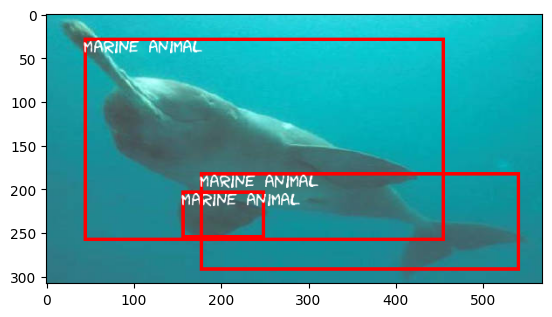

In [ ]:
# TESTING AND VISUALIZATION

# visualization of bound-boxes associated with the objects (marine animal)
import pdb
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random
font                = ImageFont.truetype("/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf", 20)


device              = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only - background and person
INSTANCE_CATEGORY_NAMES = {0:'background', 1:'marine animal'}
num_classes         = 2
model               = FasterRCNN(num_classes)
model.to(device)
model.load_state_dict(torch.load(root + '/output/faster_rcnn_model_finetuned.pth'))
model.eval()

test_sample_index    = 0
# ---------------------- ATTENTION: -----------------------------------------------------------------------------
# MANUALLY CHANGE THE FOLLOWING VARIABLE'S VALUE TO OBSERVE OUTPUT FOR 10 DIFFERENT TEST SAMPLES: 0, 1, 2, ..., 9
target_sample_index  = 4
# ---------------------- ATTENTION: -----------------------------------------------------------------------------

data_iter = iter(data_loader_test)
#for i, batch in enumerate(data_loader_test, start=start_offset):
while test_sample_index < len(data_loader_test):

    images, targets  = next(data_iter)
    # show the image
    if test_sample_index == target_sample_index:
      print(f"Running Inference on test sample# {test_sample_index}")
      break
    else:
      print(f"Not running inference on test sample# {test_sample_index}")
    # adjust the counter
    test_sample_index = test_sample_index + 1




images            = list(image.to(device) for image in images)
targets           = [{k: v for k, v in t.items()} for t in targets]
predictions       = model(images)
print(predictions)


# visualize one of the images before running the inference
SELECTED_IMAGE_INDEX = 0 # Change it to one of the values: 0, 1, 2, or 3 (if your test_loader batchsize=4). This will display the results for different images.
img               = images[SELECTED_IMAGE_INDEX].cpu().numpy() # we have a batch of 4 images
img               = img.transpose(1, 2, 0)
#print(f"image shape is: {img.shape}")


# draw the bounding boxes using PIL.ImageDraw, as we did in our in-class activity #1
rgb_image         = 255*images[SELECTED_IMAGE_INDEX].cpu().numpy() # after reading as PIL.Image, the array entries get values that range between [0-1]
rgb_image         = rgb_image.transpose(1, 2, 0)
rgb_image         = rgb_image.astype(np.uint8)
rgb_pil_img       = Image.fromarray(rgb_image)
rgb_pil_img       = rgb_pil_img.convert('RGB')
draw              = ImageDraw.Draw(rgb_pil_img)

# draw rectangular bouding boxes on the image
boxes             = predictions[SELECTED_IMAGE_INDEX]['boxes']
labels            = predictions[SELECTED_IMAGE_INDEX]['labels']
scores            = predictions[SELECTED_IMAGE_INDEX]['scores']

font_size         = 70

for i in range(len(boxes)):
    box         = boxes[i].detach().cpu().numpy()
    box         = box.astype(int)
    label_id    = labels[i].cpu()
    label_name  = INSTANCE_CATEGORY_NAMES[label_id.item()]
    score       = scores[i]
    # print(f"bounding boxes: \n{box} for label={label_name}")

    # draw a rectangular bounding box on the image to display the detection result.

    # ---------------------- ATTENTION: -----------------------------------------------------------------------------
    # MANUALLY CHANGE THE FOLLOWING THRESHOLD VALUE TO A NUMBER BETWEEN 0.0 AND 1.0
    # HIGHER THRESHOLD VALUE (eg, 0.8 or 0.9) DENOTES MORE CONFIDENT PREDICTION
    if score > 0.5: # only display the detected objects with reliable predictions.
    # ---------------------- ATTENTION: -----------------------------------------------------------------------------

      draw.rectangle([box[0], box[1], box[2], box[3] ], outline="red", width=4)
      text_x_coord, text_y_coord = box[0], box[1]
      draw.text((text_x_coord, text_y_coord), label_name, font=font, fill=(255, 255, 255))


plt.imshow(np.asarray(rgb_pil_img))


#**Write down your observations**:

>> Out of 10 test samples, in how many images were objects correctly identified without adjusting the threshold value from 0.5? You can copy the code snippet above into 10 separate cells to display your results explicitly. **(2 point)**


>> Out of 10 test samples, in how many images were objects completely missed? Additionally, note if any objects were missed due to occlusion or other challenges. **(1 point)**

